In [1]:
#!pip install tensorflow==2.7.0

In [2]:
#pip install opencv-python-headless

In [3]:
from distutils import extension
from logging import exception
import os
from datetime import datetime as dt
from regex import E
from sqlalchemy import intersect
import tensorflow as tf
from tensorflow import keras
import cv2
import numpy as np 
import pathlib
from keras.callbacks import ModelCheckpoint   
from keras.regularizers import l2
import matplotlib.pyplot as plt

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
!ls "/content/gdrive/MyDrive/cbisddsm"

Test_output_full  Test_output_mask  Train_output_full  Train_output_mask


In [6]:
# data_dir_train = pathlib.Path("/content/gdrive/MyDrive/Images/Train")
# data_dir_test = pathlib.Path('/content/gdrive/MyDrive/Images/Test')

In [7]:
seed = 43
encoder_input_width = 224
encode_input_channels = 3
encoder_input_shape = (encoder_input_width, encoder_input_width, encode_input_channels)

kernsize = 3
decoder_kernel_size = (kernsize, kernsize)
stride = 2
decoder_strides = (stride, stride)
decoder_padding = "same"
decoder_activation = None
final_layer_filters = 1
final_layer_activation = "sigmoid"

train_full_img_dir = "/content/gdrive/MyDrive/cbisddsm/Train_output_full"
train_mask_img_dir = "/content/gdrive/MyDrive/cbisddsm/Train_output_mask"

test_full_img_dir = "/content/gdrive/MyDrive/cbisddsm/Test_output_full"
test_mask_img_dir = "/content/gdrive/MyDrive/cbisddsm/Test_output_mask"
results_dir = "/content/results/fit"
extension = ".png"

target_size = (224, 224)

brightness_delta = 0.3
batch_size = 10

weight_decay = 1e-5

validate = False
loss = "binary_crossentropy"
learning_rate = 0.0001
dropout = 0.5
dropout_training = True
num_epochs = 100
callback_monitor = "iouMetric"
callback_mode = "max"
ckpt_save_weights_only = True
ckpt_save_best_only = True
earlystop_patience = 200
restore_best_weights = True

In [8]:
# x_paths_list = []
# for full in os.listdir(train_full_img_dir):
#   if full.endswith(extension):
#     x_paths_list.append(os.path.join(train_full_img_dir, full))

# print(len(x_paths_list))

In [9]:
def datasetPaths(full_img_dir, mask_img_dir):
        try:
            x_paths_list = []
            y_paths_list = []

            for full in os.listdir(full_img_dir):
                if full.endswith(extension):
                    x_paths_list.append(os.path.join(full_img_dir, full))
            
            for full in os.listdir(mask_img_dir):
                if full.endswith(extension):
                    y_paths_list.append(os.path.join(mask_img_dir, full))
            
            x_paths_list.sort()
            y_paths_list.sort()

            return x_paths_list, y_paths_list
        except Exception as e:
            print(f"Error in datasetPaths {e}")

In [10]:
# def loadFullImg(path, dsize):
#         try:
#             if not isinstance(path, str):
#                 path = path.decode()
             
            
#             s3_client = boto3.resource('s3')
#             obj = s3_client.get_object(Bucket='cbisddsm', Key=path)
#             nparr = np.frombuffer(obj['Body'].read(), np.uint8)
#             img = cv2.imdecode(nparr, cv2.IMREAD_COLOR)
#             print(f'type type{img}')
#             #bucket = s3_resource.Bucket('cbisddsm')
#             #print(f'bucket.Object(path) {bucket.Object(path)}')
#             #img = bucket.Object(path).get().get('Body').read()
#             #print(f'img {img}')
#             #img = cv2.imdecode(np.asarray(bytearray(img)), cv2.IMREAD_COLOR)
           
            
#             #img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
#             img = cv2.resize(src=img, dsize=dsize)

#             norm_img = (img - img.min()) / (img.max() - img.min())

#             full_img = np.stack([norm_img, norm_img, norm_img], axis=-1)
#             print(f'done for path {path}')
#             return full_img
        
#         except Exception as e:
#             print(f"There is an error in loadFullImg {e}")
            

    
 

In [11]:
def loadFullImg(path, dsize):
        try:
            if not isinstance(path, str):
                path = path.decode()
            
            img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
            #print(type(img))
            img = cv2.resize(src=img, dsize=dsize)

            norm_img = (img - img.min()) / (img.max() - img.min())
            #print(f'After norm_img')
            #print(f'type {norm_img.shape}')
            full_img = np.stack([norm_img, norm_img, norm_img], axis=-1)
            #print(f'After full_img')
            #print(f'type {full_img.shape}')
            #print(f'done for path {path} with shape {full_img.shape}')
            return full_img
        
        except Exception as e:
            print(f"There is an error in loadFullImg {e}")

In [12]:
# s3 = boto3.resource('s3')
# my_bucket = s3.Bucket('cbisddsm')
# i = 0
# for object_summary in my_bucket.objects.filter(Prefix='Train_output_full'):    
#     if i == 0:
#         pass
#     else:
#         print(object_summary.key)
#         img = loadFullImg(object_summary.key, target_size)
#         print(img.shape)
#         #break
#     i += 1
    
    
#             #print(object_summary.key)
        
#             #x_paths_list.append(object_summary.key)


In [13]:
def loadMaskImg(path, dsize):
        try:
            if not isinstance(path, str):
                path=path.decode()
            
            img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(src=img, dsize=dsize)

            norm_img = (img - img.min()) / (img.max() - img.min())

            mask_img = np.expand_dims(norm_img, axis=-1)
            #print(f'done for path {path} with shape {mask_img.shape}')
            return mask_img

        except Exception as e:
            print(f"Error in loadMaskIMG {e}")

In [14]:
# def loadMaskImg(path, dsize):
#         try:
#             if not isinstance(path, str):
#                 path=path.decode()
             
#             s3_resource = boto3.resource('s3')
#             bucket = s3_resource.Bucket('cbisddsm')
# #             bucket = s3_resource.Bucket('cbisddsm')
#             img = bucket.Object(path).get().get('Body').read()
#             img = cv2.imdecode(np.asarray(bytearray(img)), cv2.IMREAD_COLOR)
#             print(f'type type(img)')
#             #img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
#             img = cv2.resize(src=img, dsize=dsize)

#             norm_img = (img - img.min()) / (img.max() - img.min())

#             mask_img = np.expand_dims(norm_img, axis=-1)

#             return mask_img

#         except Exception as e:
#             print("Error in loadMaskIMG")

In [15]:
def tfParse(x_path, y_path):
        try:
            def _parse(x_path, y_path):
                x = loadFullImg(path=x_path, dsize=target_size)
                y = loadMaskImg(path=y_path, dsize=target_size)
                return x,y

            x, y = tf.numpy_function(_parse, [x_path, y_path], [tf.float64, tf.float64])

            x.set_shape([target_size[0], target_size[0], 3])
            y.set_shape([target_size[0], target_size[1], 1])

            return x,y
            

        except Exception as e:
            print(f"Error in tfParse {e}")

In [16]:
def imgAugment(x_img, y_img):
        try:
            if tf.random.uniform(()) > 0.5:
                x_img = tf.image.flip_up_down(image=x_img)
                y_img = tf.image.flip_up_down(image=y_img)

            x_img = tf.image.random_brightness(
                image=x_img, max_delta=brightness_delta
            )

            return x_img, y_img

        except:
            print("Erro in imgAugument")

In [17]:
 def makeTFDataset( shuffle, augument, x_paths_list, y_paths_list, batch_size):
        try:
            ds = tf.data.Dataset.from_tensor_slices((x_paths_list, y_paths_list))
            
            if shuffle:
                ds = ds.shuffle(buffer_size=len(x_paths_list))

            ds = ds.map(tfParse, num_parallel_calls=tf.data.experimental.AUTOTUNE)
            
            if augument:
                ds = ds.map(imgAugment, num_parallel_calls=tf.data.experimental.AUTOTUNE)

            ds = ds.batch(batch_size=batch_size, drop_remainder=False)
            ds = ds.repeat()

            return ds

        except Exception as e:
            print(f"Error in make TFDataset {e}")

In [18]:
def buildEncoder():
        try:
            VGG16_ = keras.applications.VGG16(
                include_top=False, weights="imagenet", input_shape=encoder_input_shape,
            )

            layer_names = [layer.name for layer in VGG16_.layers]

            all_layer_outputs = [
               VGG16_.get_layer(layer).output for layer in layer_names
            ]

            encoder_model = keras.Model(inputs=VGG16_.input, outputs=all_layer_outputs)

            encoder_model.trainable = False

            return encoder_model 
        
        except Exception as e:
            print("Error in buildEncoder")

In [19]:
def buildUnet():
        try:
            unet_input = keras.Input(
                shape= encoder_input_shape, name="unet_input_layer"
            )

            x = unet_input
            encoder_model = buildEncoder()
            all_encoder_layer_outputs = encoder_model(x)

            encoded_img = all_encoder_layer_outputs[-1]

            #skip_outputs = [all_encoder_layer_outputs[i] for i in [2, 5,9, 13, 17]]
            skip_outputs = [all_encoder_layer_outputs[i] for i in [2, 4, 6, 12, 15]]
            
            decoder_filters = int(encoded_img.shape[-1])

            # ------------------------------------------
            # Block 5: 7x7 -> 14x14
            #  - `encoded_img` as initial input for decoder
            x = keras.layers.Conv2DTranspose(
                name="block5_up_convT",
                filters=decoder_filters,
                kernel_size=decoder_kernel_size,
                strides=decoder_strides,
                padding=decoder_padding,
                kernel_regularizer=l2(weight_decay), 
                activation=decoder_activation,
            )(encoded_img)

            x = keras.layers.Concatenate(name="block5_up_concat", axis=-1)(
                [x, skip_outputs[4]]
            )

            x = keras.layers.Dropout(
                name="block5_up_dropout", rate=dropout, seed=seed
            )(x, training=dropout_training)

            x = keras.layers.Conv2D(
                name="block5_up_conv3",
                filters=decoder_filters,
                kernel_size=decoder_kernel_size,
                strides=(1, 1),
                padding="same",
                kernel_regularizer=l2(weight_decay), 
                activation="relu",
            )(x)
            x = keras.layers.Conv2D(
                name="block5_up_conv2",
                filters=decoder_filters,
                kernel_size=decoder_kernel_size,
                strides=(1, 1),
                padding="same",
                kernel_regularizer=l2(weight_decay), 
                activation="relu",
            )(x)
            x = keras.layers.Conv2D(
                name="block5_up_conv1",
                filters=decoder_filters,
                kernel_size=decoder_kernel_size,
                strides=(1, 1),
                kernel_regularizer=l2(weight_decay), 
                padding="same",
                activation="relu",
            )(x)

            # ------------------------------------------
            # Block 4: 14x14 -> 28x28
            x = keras.layers.Conv2DTranspose(
                name="block4_up_convT",
                filters=decoder_filters,
                kernel_size=decoder_kernel_size,
                strides=decoder_strides,
                padding=decoder_padding,
                kernel_regularizer=l2(weight_decay), 
                activation=decoder_activation,
            )(x)

            x = keras.layers.Concatenate(name="block4_up_concat", axis=-1)(
                [x, skip_outputs[3]]
            )

            x = keras.layers.Dropout(
                name="block4_up_dropout", rate=dropout, seed=seed
            )(x, training=dropout_training)

            x = keras.layers.Conv2D(
                name="block4_up_conv3",
                filters=decoder_filters,
                kernel_size=decoder_kernel_size,
                strides=(1, 1),
                padding="same",
                kernel_regularizer=l2(weight_decay), 
                activation="relu",
            )(x)
            x = keras.layers.Conv2D(
                name="block4_up_conv2",
                filters=decoder_filters,
                kernel_size=decoder_kernel_size,
                strides=(1, 1),
                padding="same",
                kernel_regularizer=l2(weight_decay), 
                activation="relu",
            )(x)
            x = keras.layers.Conv2D(
                name="block4_up_conv1",
                filters=decoder_filters,
                kernel_size=decoder_kernel_size,
                strides=(1, 1),
                padding="same",
                kernel_regularizer=l2(weight_decay), 
                activation="relu",
            )(x)

            # ------------------------------------------
            # Block 3: 28x28 -> 56x56
            x = keras.layers.Conv2DTranspose(
                name="block3_up_convT",
                filters=int(decoder_filters / 2),
                kernel_size=decoder_kernel_size,
                strides=decoder_strides,
                padding=decoder_padding,
                kernel_regularizer=l2(weight_decay), 
                activation=decoder_activation,
            )(x)

            x = keras.layers.Concatenate(name="block3_up_concat", axis=-1)(
                [x, skip_outputs[2]]
            )

            x = keras.layers.Dropout(
                name="block3_up_dropout", rate=dropout, seed=seed
            )(x, training=dropout_training)

            x = keras.layers.Conv2D(
                name="block3_up_conv3",
                filters=int(decoder_filters / 2),
                kernel_size=decoder_kernel_size,
                strides=(1, 1),
                padding="same",
                kernel_regularizer=l2(weight_decay), 
                activation="relu",
            )(x)
            x = keras.layers.Conv2D(
                name="block3_up_conv2",
                filters=int(decoder_filters / 2),
                kernel_size=decoder_kernel_size,
                strides=(1, 1),
                kernel_regularizer=l2(weight_decay), 
                padding="same",
                activation="relu",
            )(x)
            x = keras.layers.Conv2D(
                name="block3_up_conv1",
                filters=int(decoder_filters / 2),
                kernel_size=decoder_kernel_size,
                kernel_regularizer=l2(weight_decay), 
                strides=(1, 1),
                padding="same",
                activation="relu",
            )(x)

            # ------------------------------------------
            # Block 2: 56x56 -> 112x112
            x = keras.layers.Conv2DTranspose(
                name="block2_up_convT",
                filters=int(decoder_filters / 4),
                kernel_size=decoder_kernel_size,
                strides=decoder_strides,
                padding=decoder_padding,
                kernel_regularizer=l2(weight_decay), 
                activation=decoder_activation,
            )(x)

            x = keras.layers.Concatenate(name="block2_up_concat", axis=-1)(
                [x, skip_outputs[1]]
            )

            x = keras.layers.Dropout(
                name="block2_up_dropout", rate=dropout, seed=seed
            )(x, training=dropout_training)

            x = keras.layers.Conv2D(
                name="block2_up_conv2",
                filters=int(decoder_filters / 4),
                kernel_size=decoder_kernel_size,
                strides=(1, 1),
                kernel_regularizer=l2(weight_decay), 
                padding="same",
                activation="relu",
            )(x)
            x = keras.layers.Conv2D(
                name="block2_up_conv1",
                filters=int(decoder_filters / 4),
                kernel_size=decoder_kernel_size,
                strides=(1, 1),
                kernel_regularizer=l2(weight_decay), 
                padding="same",
                activation="relu",
            )(x)

            # ------------------------------------------
            # Block 1: 112x112 -> 224x224
            x = keras.layers.Conv2DTranspose(
                name="block1_up_convT",
                filters=int(decoder_filters / 8),
                kernel_size=decoder_kernel_size,
                strides=decoder_strides,
                padding=decoder_padding,
                kernel_regularizer=l2(weight_decay), 
                activation=decoder_activation,
            )(x)

            x = keras.layers.Concatenate(name="block1_up_concat", axis=-1)(
                [x, skip_outputs[0]]
            )

            x = keras.layers.Dropout(
                name="block1_up_dropout", rate=dropout, seed=seed
            )(x, training=dropout_training)

            x = keras.layers.Conv2D(
                name="block1_up_conv2",
                filters=int(decoder_filters / 8),
                kernel_size=decoder_kernel_size,
                strides=(1, 1),
                padding="same",
                kernel_regularizer=l2(weight_decay), 
                activation="relu",
            )(x)
            decoded_img = keras.layers.Conv2D(
                name="block1_up_conv1",
                filters=int(decoder_filters / 8),
                kernel_size=decoder_kernel_size,
                strides=(1, 1),
                padding="same",
                kernel_regularizer=l2(weight_decay), 
                activation="relu",
            )(x)

            # ------------------------------------------
            # Final conv layer
            final_img = keras.layers.Conv2D(
                name="final_up_conv",
                filters=final_layer_filters,
                kernel_size=decoder_kernel_size,
                strides=(1, 1),
                padding="same",
                kernel_regularizer=l2(weight_decay), 
                activation=final_layer_activation,
            )(decoded_img)

            # ======
            #  Unet
            # ======

            unet = keras.Model(inputs=unet_input, outputs=final_img, name="Unet_VGG16")

            return unet
        except Exception as e:
            print(f"Error in Build Unet {e}")

In [20]:
def iouMetric( y_true, y_pred):
        try:
            def compute_iou(y_true, y_pred):
                intersection = (y_true * y_pred).sum()
                union = y_true.sum() + y_pred.sum() - intersection
                x = (intersection + 1e-15) / (union + 1e-15)
                x = x.astype(np.float32)
                return x
            
            return tf.numpy_function(compute_iou, [y_true, y_pred], tf.float32)
            
        except Exception as e:
            print(f"Error in iouMetric {E}")

In [21]:
def dice_coef(y_true, y_pred):
        try:
            # def dice(true, pred, k = 1):
            #     intersection = np.sum(pred[true==k]) * 2.0
            #     dice = intersection / (np.sum(pred) + np.sum(true))
            #     return dice 
            # return tf.numpy_function(dice, [y_true, y_pred], tf.double)
            
            y_true_f = tf.reshape(tf.dtypes.cast(y_true, tf.float32), [-1])
            y_pred_f = tf.reshape(tf.dtypes.cast(y_pred, tf.float32), [-1])
            intersection = tf.reduce_sum(y_true_f * y_pred_f)
            return (2. * intersection + 1.) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + 1.)
        except Exception as e:
            print(f"Error in dice_coef {e}")

In [22]:
def compile_( model):
        try:
            loss = keras.losses.BinaryCrossentropy(from_logits=False)
            optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
            metrics = ["accuracy", iouMetric, dice_coef]
            model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

            return model
        except Exception as e:
            print(f"Failed at compile_ {e}")

In [23]:
 test_x, test_y = datasetPaths(
            full_img_dir=test_full_img_dir,
            mask_img_dir=test_mask_img_dir
        )
        

In [24]:
# def evaluate(path,target_size):
#   full_img_lst = []
#   print(len(path))
#   for imgpath in path:
#     full_img = loadFullImg(imgpath, target_size)
#     full_img_lst.append(full_img)
#     #img = cv2.imread(imgpath, cv2.IMREAD_GRAYSCALE)
#     #print(full_img.shape)
#   return full_img_lst
  
# full_img_lst = evaluate(test_x, target_size)

In [25]:
# def evaluate_mask(path,target_size):
#   mask_img_lst = []
#   print(len(path))
#   for imgpath in path:
#     mask_img = loadMaskImg(imgpath, target_size)
#     mask_img_lst.append(mask_img)
#     #img = cv2.imread(imgpath, cv2.IMREAD_GRAYSCALE)
#     #print(full_img.shape)
#   return mask_img_lst
  
# mask_img_lst = evaluate(test_y, target_size)

In [26]:
# img = cv2.imread(test_x[0], cv2.IMREAD_GRAYSCALE)
# print(img)

In [27]:
# actual_x, actual_y =tfParse(test_x, test_y)

In [28]:
# full_img_lst[0]

In [29]:
checkpointer = ModelCheckpoint(filepath='model.weights.best.hdf5', verbose=1, save_best_only=True)  
model_time = dt.now().strftime("%Y%m%d_%H%M%S")
model_folder = os.path.join(results_dir, model_time)
os.makedirs(model_folder)

tensorboard_folder = os.path.join(model_folder, "tensorlogs")
os.makedirs(tensorboard_folder)

ckpt_folder = os.path.join(model_folder, "checkpoints")
os.makedirs(ckpt_folder)

csv_logger_folder = os.path.join(model_folder, "csv_logger")
os.makedirs(csv_logger_folder)

hist_folder = os.path.join(model_folder, "model_history")
os.makedirs(hist_folder)

saved_model_folder = os.path.join(model_folder, "Saved_model")
os.makedirs(saved_model_folder)

model_params_folder = os.path.join(model_folder, "model_params")
os.makedirs(model_params_folder)

train_x, train_y = datasetPaths(
    full_img_dir=train_full_img_dir,
    mask_img_dir=train_mask_img_dir 
)

test_x, test_y = datasetPaths(
    full_img_dir=test_full_img_dir,
    mask_img_dir=test_mask_img_dir
)

train_ds = makeTFDataset(shuffle=True, augument=True,
x_paths_list = train_x, y_paths_list=train_y, batch_size=batch_size)


test_ds = makeTFDataset(
    shuffle=False,
    augument=False,
    x_paths_list=test_x,
    y_paths_list=test_y,
    batch_size=batch_size)      
    
unet = buildUnet()

unet = compile_(model=unet)

# ckpt_path = (ckpt_folder + f"/{model_time}" + "_Epoch-{epoch:03d}" + "_IOU-{iouMetric:.8f")
ckpt_path = (ckpt_folder + f"/{model_time}")

ckpt_callback = keras.callbacks.ModelCheckpoint(
    filepath= ckpt_path,
    monitors= callback_monitor,
    mode= callback_mode,
    save_weights_only= ckpt_save_weights_only,
    save_best_only=ckpt_save_best_only,
    verbose=1
)

es_callback = keras.callbacks.EarlyStopping(
    patience= earlystop_patience,
    monitor= callback_monitor,
    mode= callback_mode,
    restore_best_weights= restore_best_weights,
)

# TensorBoard
tb_callback = keras.callbacks.TensorBoard(
    log_dir=tensorboard_folder, histogram_freq=1, profile_batch=0
)

# CSV Logger
csv_logger_path = os.path.join(csv_logger_folder, "csv_logger.csv")
csv_logger = keras.callbacks.CSVLogger(
    filename=csv_logger_path, separator=",", append=True
)

# Putting them together
callbacks = [ckpt_callback, es_callback, tb_callback, csv_logger, checkpointer]

train_steps = len(train_x) // batch_size
test_steps = len(test_x) // batch_size

if len(train_x) % batch_size != 0:
    train_steps += 1
if len(test_x) % batch_size != 0:
    test_steps += 1

print()
print(f"Size of training set = {len(train_x)}")
print(f"Size of test set = {len(test_x)}")
print(f"Number of epochs = {num_epochs}")
print(f"Batch size = {batch_size}")
print(f"Number of training steps per epoch = {train_steps}")
print(f"Number of test steps per epoch = {test_steps}")
print()

if validate:
        history = unet.fit(
            train_ds,
            validation_data=test_ds,
            epochs=num_epochs,
            steps_per_epoch=train_steps,
            validation_steps=test_steps,
            callbacks=callbacks,
            verbose=1,
        )
elif not validate:
    history = unet.fit(
        train_ds,
        epochs=num_epochs,
        steps_per_epoch=train_steps,
        callbacks=callbacks,
        verbose=1
    )

#y_hat = unet.evaluate(test_ds)

print("Completed")     
        

58900480/58889256 [==============================] - 0s 0us/step

Size of training set = 1231
Size of test set = 361
Number of epochs = 100
Batch size = 10
Number of training steps per epoch = 124
Number of test steps per epoch = 37

Epoch 1/100
124/124 [==============================] - ETA: 0s - loss: 0.1023 - accuracy: 0.9883 - iouMetric: 0.0078 - dice_coef: 0.0156

124/124 [==============================] - 384s 3s/step - loss: 0.1023 - accuracy: 0.9883 - iouMetric: 0.0078 - dice_coef: 0.0156
Epoch 2/100
123/124 [============================>.] - ETA: 1s - loss: 0.0526 - accuracy: 0.9959 - iouMetric: 0.0793 - dice_coef: 0.1453

124/124 [==============================] - 200s 2s/step - loss: 0.0525 - accuracy: 0.9958 - iouMetric: 0.0787 - dice_coef: 0.1442
Epoch 3/100
123/124 [============================>.] - ETA: 1s - loss: 0.0397 - accuracy: 0.9961 - iouMetric: 0.1141 - dice_coef: 0.2023

124/124 [==============================] - 200s 2s/step - loss: 0.0397 - accuracy: 0.9961 - iouMetric: 0.1139 - dice_coef: 0.2019
Epoch 4/100
124/124 [==============================] - ETA: 0s - loss: 0.0337 - accuracy: 0.9962 - iouMetric: 0.1273 - dice_coef: 0.2220

124/124 [==============================] - 200s 2s/step - loss: 0.0337 - accuracy: 0.9962 - iouMetric: 0.1273 - dice_coef: 0.2220
Epoch 5/100
124/124 [==============================] - ETA: 0s - loss: 0.0303 - accuracy: 0.9963 - iouMetric: 0.1465 - dice_coef: 0.2501

124/124 [==============================] - 200s 2s/step - loss: 0.0303 - accuracy: 0.9963 - iouMetric: 0.1465 - dice_coef: 0.2501
Epoch 6/100
124/124 [==============================] - ETA: 0s - loss: 0.0279 - accuracy: 0.9964 - iouMetric: 0.1502 - dice_coef: 0.2575

124/124 [==============================] - 200s 2s/step - loss: 0.0279 - accuracy: 0.9964 - iouMetric: 0.1502 - dice_coef: 0.2575
Epoch 7/100
123/124 [============================>.] - ETA: 1s - loss: 0.0263 - accuracy: 0.9965 - iouMetric: 0.1625 - dice_coef: 0.2742

124/124 [==============================] - 201s 2s/step - loss: 0.0263 - accuracy: 0.9965 - iouMetric: 0.1619 - dice_coef: 0.2734
Epoch 8/100
123/124 [============================>.] - ETA: 1s - loss: 0.0250 - accuracy: 0.9965 - iouMetric: 0.1684 - dice_coef: 0.2829

124/124 [==============================] - 200s 2s/step - loss: 0.0250 - accuracy: 0.9965 - iouMetric: 0.1671 - dice_coef: 0.2808
Epoch 9/100
123/124 [============================>.] - ETA: 1s - loss: 0.0241 - accuracy: 0.9966 - iouMetric: 0.1701 - dice_coef: 0.2862

124/124 [==============================] - 201s 2s/step - loss: 0.0241 - accuracy: 0.9966 - iouMetric: 0.1697 - dice_coef: 0.2856
Epoch 10/100
123/124 [============================>.] - ETA: 1s - loss: 0.0232 - accuracy: 0.9966 - iouMetric: 0.1808 - dice_coef: 0.3010

124/124 [==============================] - 200s 2s/step - loss: 0.0232 - accuracy: 0.9966 - iouMetric: 0.1815 - dice_coef: 0.3020
Epoch 11/100
123/124 [============================>.] - ETA: 1s - loss: 0.0225 - accuracy: 0.9966 - iouMetric: 0.1828 - dice_coef: 0.3049

124/124 [==============================] - 201s 2s/step - loss: 0.0225 - accuracy: 0.9966 - iouMetric: 0.1816 - dice_coef: 0.3030
Epoch 12/100
123/124 [============================>.] - ETA: 1s - loss: 0.0217 - accuracy: 0.9967 - iouMetric: 0.1857 - dice_coef: 0.3086

124/124 [==============================] - 201s 2s/step - loss: 0.0217 - accuracy: 0.9967 - iouMetric: 0.1844 - dice_coef: 0.3066
Epoch 13/100
123/124 [============================>.] - ETA: 1s - loss: 0.0209 - accuracy: 0.9967 - iouMetric: 0.1949 - dice_coef: 0.3202

124/124 [==============================] - 201s 2s/step - loss: 0.0209 - accuracy: 0.9967 - iouMetric: 0.1935 - dice_coef: 0.3180
Epoch 14/100
123/124 [============================>.] - ETA: 1s - loss: 0.0205 - accuracy: 0.9967 - iouMetric: 0.1932 - dice_coef: 0.3190

124/124 [==============================] - 201s 2s/step - loss: 0.0205 - accuracy: 0.9967 - iouMetric: 0.1935 - dice_coef: 0.3195
Epoch 15/100
123/124 [============================>.] - ETA: 1s - loss: 0.0200 - accuracy: 0.9968 - iouMetric: 0.1992 - dice_coef: 0.3278

124/124 [==============================] - 201s 2s/step - loss: 0.0200 - accuracy: 0.9968 - iouMetric: 0.1999 - dice_coef: 0.3288
Epoch 16/100
124/124 [==============================] - ETA: 0s - loss: 0.0191 - accuracy: 0.9969 - iouMetric: 0.2217 - dice_coef: 0.3574

124/124 [==============================] - 202s 2s/step - loss: 0.0191 - accuracy: 0.9969 - iouMetric: 0.2217 - dice_coef: 0.3574
Epoch 17/100
123/124 [============================>.] - ETA: 1s - loss: 0.0187 - accuracy: 0.9969 - iouMetric: 0.2304 - dice_coef: 0.3693

124/124 [==============================] - 201s 2s/step - loss: 0.0187 - accuracy: 0.9969 - iouMetric: 0.2301 - dice_coef: 0.3690
Epoch 18/100
124/124 [==============================] - ETA: 0s - loss: 0.0181 - accuracy: 0.9970 - iouMetric: 0.2378 - dice_coef: 0.3792

124/124 [==============================] - 202s 2s/step - loss: 0.0181 - accuracy: 0.9970 - iouMetric: 0.2378 - dice_coef: 0.3792
Epoch 19/100
124/124 [==============================] - ETA: 0s - loss: 0.0178 - accuracy: 0.9969 - iouMetric: 0.2326 - dice_coef: 0.3717

124/124 [==============================] - 201s 2s/step - loss: 0.0178 - accuracy: 0.9969 - iouMetric: 0.2326 - dice_coef: 0.3717
Epoch 20/100
123/124 [============================>.] - ETA: 1s - loss: 0.0173 - accuracy: 0.9971 - iouMetric: 0.2522 - dice_coef: 0.3974

124/124 [==============================] - 202s 2s/step - loss: 0.0173 - accuracy: 0.9971 - iouMetric: 0.2508 - dice_coef: 0.3952
Epoch 21/100
123/124 [============================>.] - ETA: 1s - loss: 0.0169 - accuracy: 0.9971 - iouMetric: 0.2540 - dice_coef: 0.3977

124/124 [==============================] - 205s 2s/step - loss: 0.0169 - accuracy: 0.9971 - iouMetric: 0.2535 - dice_coef: 0.3970
Epoch 22/100
124/124 [==============================] - ETA: 0s - loss: 0.0167 - accuracy: 0.9971 - iouMetric: 0.2561 - dice_coef: 0.4024

124/124 [==============================] - 206s 2s/step - loss: 0.0167 - accuracy: 0.9971 - iouMetric: 0.2561 - dice_coef: 0.4024
Epoch 23/100
123/124 [============================>.] - ETA: 1s - loss: 0.0162 - accuracy: 0.9973 - iouMetric: 0.2707 - dice_coef: 0.4185

124/124 [==============================] - 207s 2s/step - loss: 0.0162 - accuracy: 0.9973 - iouMetric: 0.2712 - dice_coef: 0.4192
Epoch 24/100
123/124 [============================>.] - ETA: 1s - loss: 0.0158 - accuracy: 0.9972 - iouMetric: 0.2758 - dice_coef: 0.4254

124/124 [==============================] - 206s 2s/step - loss: 0.0158 - accuracy: 0.9972 - iouMetric: 0.2771 - dice_coef: 0.4268
Epoch 25/100
123/124 [============================>.] - ETA: 1s - loss: 0.0158 - accuracy: 0.9972 - iouMetric: 0.2631 - dice_coef: 0.4097

124/124 [==============================] - 207s 2s/step - loss: 0.0158 - accuracy: 0.9972 - iouMetric: 0.2659 - dice_coef: 0.4125
Epoch 26/100
123/124 [============================>.] - ETA: 1s - loss: 0.0151 - accuracy: 0.9974 - iouMetric: 0.2963 - dice_coef: 0.4515

124/124 [==============================] - 208s 2s/step - loss: 0.0151 - accuracy: 0.9974 - iouMetric: 0.2951 - dice_coef: 0.4499
Epoch 27/100
123/124 [============================>.] - ETA: 1s - loss: 0.0149 - accuracy: 0.9974 - iouMetric: 0.2974 - dice_coef: 0.4522

124/124 [==============================] - 208s 2s/step - loss: 0.0149 - accuracy: 0.9974 - iouMetric: 0.2962 - dice_coef: 0.4507
Epoch 28/100
123/124 [============================>.] - ETA: 1s - loss: 0.0149 - accuracy: 0.9973 - iouMetric: 0.2896 - dice_coef: 0.4429

124/124 [==============================] - 212s 2s/step - loss: 0.0149 - accuracy: 0.9973 - iouMetric: 0.2909 - dice_coef: 0.4444
Epoch 29/100
123/124 [============================>.] - ETA: 1s - loss: 0.0144 - accuracy: 0.9974 - iouMetric: 0.3107 - dice_coef: 0.4678

124/124 [==============================] - 210s 2s/step - loss: 0.0144 - accuracy: 0.9974 - iouMetric: 0.3082 - dice_coef: 0.4643
Epoch 30/100
124/124 [==============================] - ETA: 0s - loss: 0.0144 - accuracy: 0.9974 - iouMetric: 0.2998 - dice_coef: 0.4536

124/124 [==============================] - 209s 2s/step - loss: 0.0144 - accuracy: 0.9974 - iouMetric: 0.2998 - dice_coef: 0.4536
Epoch 31/100
123/124 [============================>.] - ETA: 1s - loss: 0.0138 - accuracy: 0.9975 - iouMetric: 0.3254 - dice_coef: 0.4844

124/124 [==============================] - 210s 2s/step - loss: 0.0138 - accuracy: 0.9975 - iouMetric: 0.3232 - dice_coef: 0.4816
Epoch 32/100
124/124 [==============================] - ETA: 0s - loss: 0.0135 - accuracy: 0.9976 - iouMetric: 0.3273 - dice_coef: 0.4865

124/124 [==============================] - 210s 2s/step - loss: 0.0135 - accuracy: 0.9976 - iouMetric: 0.3273 - dice_coef: 0.4865
Epoch 33/100
123/124 [============================>.] - ETA: 1s - loss: 0.0133 - accuracy: 0.9975 - iouMetric: 0.3291 - dice_coef: 0.4888

124/124 [==============================] - 210s 2s/step - loss: 0.0133 - accuracy: 0.9975 - iouMetric: 0.3283 - dice_coef: 0.4878
Epoch 34/100
123/124 [============================>.] - ETA: 1s - loss: 0.0131 - accuracy: 0.9976 - iouMetric: 0.3418 - dice_coef: 0.5029

124/124 [==============================] - 208s 2s/step - loss: 0.0131 - accuracy: 0.9976 - iouMetric: 0.3407 - dice_coef: 0.5016
Epoch 35/100
124/124 [==============================] - ETA: 0s - loss: 0.0129 - accuracy: 0.9976 - iouMetric: 0.3417 - dice_coef: 0.5031

124/124 [==============================] - 214s 2s/step - loss: 0.0129 - accuracy: 0.9976 - iouMetric: 0.3417 - dice_coef: 0.5031
Epoch 36/100
123/124 [============================>.] - ETA: 1s - loss: 0.0127 - accuracy: 0.9977 - iouMetric: 0.3523 - dice_coef: 0.5149

124/124 [==============================] - 204s 2s/step - loss: 0.0127 - accuracy: 0.9977 - iouMetric: 0.3518 - dice_coef: 0.5144
Epoch 37/100
123/124 [============================>.] - ETA: 1s - loss: 0.0122 - accuracy: 0.9978 - iouMetric: 0.3752 - dice_coef: 0.5390

124/124 [==============================] - 207s 2s/step - loss: 0.0122 - accuracy: 0.9978 - iouMetric: 0.3731 - dice_coef: 0.5362
Epoch 38/100
123/124 [============================>.] - ETA: 1s - loss: 0.0124 - accuracy: 0.9977 - iouMetric: 0.3573 - dice_coef: 0.5205

124/124 [==============================] - 206s 2s/step - loss: 0.0124 - accuracy: 0.9977 - iouMetric: 0.3589 - dice_coef: 0.5220
Epoch 39/100
123/124 [============================>.] - ETA: 1s - loss: 0.0121 - accuracy: 0.9977 - iouMetric: 0.3653 - dice_coef: 0.5289

124/124 [==============================] - 209s 2s/step - loss: 0.0121 - accuracy: 0.9977 - iouMetric: 0.3669 - dice_coef: 0.5305
Epoch 40/100
123/124 [============================>.] - ETA: 1s - loss: 0.0118 - accuracy: 0.9978 - iouMetric: 0.3829 - dice_coef: 0.5484

124/124 [==============================] - 208s 2s/step - loss: 0.0118 - accuracy: 0.9978 - iouMetric: 0.3826 - dice_coef: 0.5481
Epoch 41/100
123/124 [============================>.] - ETA: 1s - loss: 0.0115 - accuracy: 0.9979 - iouMetric: 0.3908 - dice_coef: 0.5563

124/124 [==============================] - 207s 2s/step - loss: 0.0115 - accuracy: 0.9979 - iouMetric: 0.3919 - dice_coef: 0.5574
Epoch 42/100
123/124 [============================>.] - ETA: 1s - loss: 0.0116 - accuracy: 0.9978 - iouMetric: 0.3802 - dice_coef: 0.5457

124/124 [==============================] - 203s 2s/step - loss: 0.0116 - accuracy: 0.9978 - iouMetric: 0.3784 - dice_coef: 0.5436
Epoch 43/100
124/124 [==============================] - ETA: 0s - loss: 0.0115 - accuracy: 0.9978 - iouMetric: 0.3812 - dice_coef: 0.5462

124/124 [==============================] - 203s 2s/step - loss: 0.0115 - accuracy: 0.9978 - iouMetric: 0.3812 - dice_coef: 0.5462
Epoch 44/100
124/124 [==============================] - ETA: 0s - loss: 0.0112 - accuracy: 0.9979 - iouMetric: 0.3921 - dice_coef: 0.5586

124/124 [==============================] - 203s 2s/step - loss: 0.0112 - accuracy: 0.9979 - iouMetric: 0.3921 - dice_coef: 0.5586
Epoch 45/100
123/124 [============================>.] - ETA: 1s - loss: 0.0111 - accuracy: 0.9979 - iouMetric: 0.3991 - dice_coef: 0.5654

124/124 [==============================] - 214s 2s/step - loss: 0.0111 - accuracy: 0.9979 - iouMetric: 0.3976 - dice_coef: 0.5637
Epoch 46/100
124/124 [==============================] - ETA: 0s - loss: 0.0110 - accuracy: 0.9979 - iouMetric: 0.3999 - dice_coef: 0.5654

124/124 [==============================] - 202s 2s/step - loss: 0.0110 - accuracy: 0.9979 - iouMetric: 0.3999 - dice_coef: 0.5654
Epoch 47/100
123/124 [============================>.] - ETA: 1s - loss: 0.0108 - accuracy: 0.9979 - iouMetric: 0.3997 - dice_coef: 0.5650

124/124 [==============================] - 210s 2s/step - loss: 0.0108 - accuracy: 0.9979 - iouMetric: 0.3999 - dice_coef: 0.5653
Epoch 48/100
123/124 [============================>.] - ETA: 1s - loss: 0.0107 - accuracy: 0.9979 - iouMetric: 0.4072 - dice_coef: 0.5732

124/124 [==============================] - 204s 2s/step - loss: 0.0107 - accuracy: 0.9979 - iouMetric: 0.4086 - dice_coef: 0.5745
Epoch 49/100
123/124 [============================>.] - ETA: 1s - loss: 0.0108 - accuracy: 0.9979 - iouMetric: 0.3971 - dice_coef: 0.5636

124/124 [==============================] - 210s 2s/step - loss: 0.0108 - accuracy: 0.9979 - iouMetric: 0.3958 - dice_coef: 0.5622
Epoch 50/100
123/124 [============================>.] - ETA: 1s - loss: 0.0106 - accuracy: 0.9979 - iouMetric: 0.4039 - dice_coef: 0.5702

124/124 [==============================] - 207s 2s/step - loss: 0.0106 - accuracy: 0.9979 - iouMetric: 0.4024 - dice_coef: 0.5685
Epoch 51/100
124/124 [==============================] - ETA: 0s - loss: 0.0104 - accuracy: 0.9979 - iouMetric: 0.4112 - dice_coef: 0.5770

124/124 [==============================] - 208s 2s/step - loss: 0.0104 - accuracy: 0.9979 - iouMetric: 0.4112 - dice_coef: 0.5770
Epoch 52/100
123/124 [============================>.] - ETA: 1s - loss: 0.0102 - accuracy: 0.9980 - iouMetric: 0.4233 - dice_coef: 0.5907

124/124 [==============================] - 207s 2s/step - loss: 0.0102 - accuracy: 0.9980 - iouMetric: 0.4239 - dice_coef: 0.5914
Epoch 53/100
124/124 [==============================] - ETA: 0s - loss: 0.0099 - accuracy: 0.9980 - iouMetric: 0.4360 - dice_coef: 0.6020

124/124 [==============================] - 210s 2s/step - loss: 0.0099 - accuracy: 0.9980 - iouMetric: 0.4360 - dice_coef: 0.6020
Epoch 54/100
123/124 [============================>.] - ETA: 1s - loss: 0.0099 - accuracy: 0.9980 - iouMetric: 0.4308 - dice_coef: 0.5968

124/124 [==============================] - 207s 2s/step - loss: 0.0099 - accuracy: 0.9980 - iouMetric: 0.4274 - dice_coef: 0.5920
Epoch 55/100
123/124 [============================>.] - ETA: 1s - loss: 0.0098 - accuracy: 0.9981 - iouMetric: 0.4286 - dice_coef: 0.5942

124/124 [==============================] - 207s 2s/step - loss: 0.0098 - accuracy: 0.9981 - iouMetric: 0.4287 - dice_coef: 0.5942
Epoch 56/100
123/124 [============================>.] - ETA: 1s - loss: 0.0098 - accuracy: 0.9980 - iouMetric: 0.4300 - dice_coef: 0.5964

124/124 [==============================] - 207s 2s/step - loss: 0.0098 - accuracy: 0.9980 - iouMetric: 0.4285 - dice_coef: 0.5947
Epoch 57/100
123/124 [============================>.] - ETA: 1s - loss: 0.0102 - accuracy: 0.9979 - iouMetric: 0.4008 - dice_coef: 0.5663

124/124 [==============================] - 207s 2s/step - loss: 0.0102 - accuracy: 0.9979 - iouMetric: 0.4041 - dice_coef: 0.5689
Epoch 58/100
123/124 [============================>.] - ETA: 1s - loss: 0.0095 - accuracy: 0.9981 - iouMetric: 0.4438 - dice_coef: 0.6102

124/124 [==============================] - 210s 2s/step - loss: 0.0095 - accuracy: 0.9981 - iouMetric: 0.4415 - dice_coef: 0.6075
Epoch 59/100
123/124 [============================>.] - ETA: 1s - loss: 0.0094 - accuracy: 0.9981 - iouMetric: 0.4389 - dice_coef: 0.6052

124/124 [==============================] - 211s 2s/step - loss: 0.0094 - accuracy: 0.9981 - iouMetric: 0.4403 - dice_coef: 0.6064
Epoch 60/100
123/124 [============================>.] - ETA: 1s - loss: 0.0092 - accuracy: 0.9981 - iouMetric: 0.4584 - dice_coef: 0.6249

124/124 [==============================] - 212s 2s/step - loss: 0.0092 - accuracy: 0.9981 - iouMetric: 0.4595 - dice_coef: 0.6258
Epoch 61/100
123/124 [============================>.] - ETA: 1s - loss: 0.0093 - accuracy: 0.9981 - iouMetric: 0.4413 - dice_coef: 0.6075

124/124 [==============================] - 204s 2s/step - loss: 0.0093 - accuracy: 0.9981 - iouMetric: 0.4412 - dice_coef: 0.6075
Epoch 62/100
123/124 [============================>.] - ETA: 1s - loss: 0.0092 - accuracy: 0.9981 - iouMetric: 0.4467 - dice_coef: 0.6130

124/124 [==============================] - 204s 2s/step - loss: 0.0092 - accuracy: 0.9981 - iouMetric: 0.4464 - dice_coef: 0.6127
Epoch 63/100
123/124 [============================>.] - ETA: 1s - loss: 0.0090 - accuracy: 0.9982 - iouMetric: 0.4539 - dice_coef: 0.6193

124/124 [==============================] - 203s 2s/step - loss: 0.0090 - accuracy: 0.9982 - iouMetric: 0.4552 - dice_coef: 0.6205
Epoch 64/100
123/124 [============================>.] - ETA: 1s - loss: 0.0091 - accuracy: 0.9981 - iouMetric: 0.4433 - dice_coef: 0.6100

124/124 [==============================] - 204s 2s/step - loss: 0.0091 - accuracy: 0.9981 - iouMetric: 0.4438 - dice_coef: 0.6104
Epoch 65/100
123/124 [============================>.] - ETA: 1s - loss: 0.0087 - accuracy: 0.9982 - iouMetric: 0.4632 - dice_coef: 0.6281

124/124 [==============================] - 205s 2s/step - loss: 0.0088 - accuracy: 0.9982 - iouMetric: 0.4626 - dice_coef: 0.6275
Epoch 66/100
123/124 [============================>.] - ETA: 1s - loss: 0.0098 - accuracy: 0.9979 - iouMetric: 0.3991 - dice_coef: 0.5643

124/124 [==============================] - 215s 2s/step - loss: 0.0098 - accuracy: 0.9979 - iouMetric: 0.4005 - dice_coef: 0.5656
Epoch 67/100
124/124 [==============================] - ETA: 0s - loss: 0.0090 - accuracy: 0.9981 - iouMetric: 0.4410 - dice_coef: 0.6063

124/124 [==============================] - 215s 2s/step - loss: 0.0090 - accuracy: 0.9981 - iouMetric: 0.4410 - dice_coef: 0.6063
Epoch 68/100
124/124 [==============================] - ETA: 0s - loss: 0.0087 - accuracy: 0.9982 - iouMetric: 0.4584 - dice_coef: 0.6245

124/124 [==============================] - 213s 2s/step - loss: 0.0087 - accuracy: 0.9982 - iouMetric: 0.4584 - dice_coef: 0.6245
Epoch 69/100
123/124 [============================>.] - ETA: 1s - loss: 0.0086 - accuracy: 0.9982 - iouMetric: 0.4671 - dice_coef: 0.6316

124/124 [==============================] - 214s 2s/step - loss: 0.0086 - accuracy: 0.9982 - iouMetric: 0.4675 - dice_coef: 0.6320
Epoch 70/100
123/124 [============================>.] - ETA: 1s - loss: 0.0084 - accuracy: 0.9982 - iouMetric: 0.4710 - dice_coef: 0.6354

124/124 [==============================] - 204s 2s/step - loss: 0.0084 - accuracy: 0.9982 - iouMetric: 0.4731 - dice_coef: 0.6371
Epoch 71/100
123/124 [============================>.] - ETA: 1s - loss: 0.0083 - accuracy: 0.9983 - iouMetric: 0.4777 - dice_coef: 0.6426

124/124 [==============================] - 210s 2s/step - loss: 0.0083 - accuracy: 0.9983 - iouMetric: 0.4770 - dice_coef: 0.6420
Epoch 72/100
123/124 [============================>.] - ETA: 1s - loss: 0.0084 - accuracy: 0.9982 - iouMetric: 0.4737 - dice_coef: 0.6391

124/124 [==============================] - 212s 2s/step - loss: 0.0084 - accuracy: 0.9982 - iouMetric: 0.4746 - dice_coef: 0.6400
Epoch 73/100
123/124 [============================>.] - ETA: 1s - loss: 0.0083 - accuracy: 0.9982 - iouMetric: 0.4765 - dice_coef: 0.6408

124/124 [==============================] - 206s 2s/step - loss: 0.0083 - accuracy: 0.9982 - iouMetric: 0.4764 - dice_coef: 0.6408
Epoch 74/100
123/124 [============================>.] - ETA: 1s - loss: 0.0081 - accuracy: 0.9982 - iouMetric: 0.4830 - dice_coef: 0.6472

124/124 [==============================] - 205s 2s/step - loss: 0.0081 - accuracy: 0.9982 - iouMetric: 0.4803 - dice_coef: 0.6442
Epoch 75/100
124/124 [==============================] - ETA: 0s - loss: 0.0086 - accuracy: 0.9981 - iouMetric: 0.4409 - dice_coef: 0.6057

124/124 [==============================] - 214s 2s/step - loss: 0.0086 - accuracy: 0.9981 - iouMetric: 0.4409 - dice_coef: 0.6057
Epoch 76/100
124/124 [==============================] - ETA: 0s - loss: 0.0080 - accuracy: 0.9982 - iouMetric: 0.4848 - dice_coef: 0.6491

124/124 [==============================] - 214s 2s/step - loss: 0.0080 - accuracy: 0.9982 - iouMetric: 0.4848 - dice_coef: 0.6491
Epoch 77/100
123/124 [============================>.] - ETA: 1s - loss: 0.0079 - accuracy: 0.9983 - iouMetric: 0.4883 - dice_coef: 0.6529

124/124 [==============================] - 208s 2s/step - loss: 0.0079 - accuracy: 0.9983 - iouMetric: 0.4871 - dice_coef: 0.6517
Epoch 78/100
123/124 [============================>.] - ETA: 1s - loss: 0.0079 - accuracy: 0.9983 - iouMetric: 0.4903 - dice_coef: 0.6539

124/124 [==============================] - 210s 2s/step - loss: 0.0079 - accuracy: 0.9983 - iouMetric: 0.4866 - dice_coef: 0.6492
Epoch 79/100
123/124 [============================>.] - ETA: 1s - loss: 0.0078 - accuracy: 0.9983 - iouMetric: 0.4899 - dice_coef: 0.6544

124/124 [==============================] - 211s 2s/step - loss: 0.0078 - accuracy: 0.9983 - iouMetric: 0.4895 - dice_coef: 0.6541
Epoch 80/100
124/124 [==============================] - ETA: 0s - loss: 0.0078 - accuracy: 0.9983 - iouMetric: 0.4876 - dice_coef: 0.6502

124/124 [==============================] - 209s 2s/step - loss: 0.0078 - accuracy: 0.9983 - iouMetric: 0.4876 - dice_coef: 0.6502
Epoch 81/100
123/124 [============================>.] - ETA: 1s - loss: 0.0079 - accuracy: 0.9983 - iouMetric: 0.4858 - dice_coef: 0.6500

124/124 [==============================] - 208s 2s/step - loss: 0.0079 - accuracy: 0.9983 - iouMetric: 0.4862 - dice_coef: 0.6504
Epoch 82/100
124/124 [==============================] - ETA: 0s - loss: 0.0076 - accuracy: 0.9983 - iouMetric: 0.4919 - dice_coef: 0.6549

124/124 [==============================] - 209s 2s/step - loss: 0.0076 - accuracy: 0.9983 - iouMetric: 0.4919 - dice_coef: 0.6549
Epoch 83/100
123/124 [============================>.] - ETA: 1s - loss: 0.0077 - accuracy: 0.9983 - iouMetric: 0.4898 - dice_coef: 0.6538

124/124 [==============================] - 209s 2s/step - loss: 0.0077 - accuracy: 0.9983 - iouMetric: 0.4900 - dice_coef: 0.6540
Epoch 84/100
123/124 [============================>.] - ETA: 1s - loss: 0.0074 - accuracy: 0.9984 - iouMetric: 0.5077 - dice_coef: 0.6704

124/124 [==============================] - 210s 2s/step - loss: 0.0074 - accuracy: 0.9984 - iouMetric: 0.5081 - dice_coef: 0.6708
Epoch 85/100
123/124 [============================>.] - ETA: 1s - loss: 0.0074 - accuracy: 0.9983 - iouMetric: 0.5071 - dice_coef: 0.6699

124/124 [==============================] - 210s 2s/step - loss: 0.0074 - accuracy: 0.9983 - iouMetric: 0.5072 - dice_coef: 0.6701
Epoch 86/100
124/124 [==============================] - ETA: 0s - loss: 0.0075 - accuracy: 0.9983 - iouMetric: 0.4964 - dice_coef: 0.6592

124/124 [==============================] - 210s 2s/step - loss: 0.0075 - accuracy: 0.9983 - iouMetric: 0.4964 - dice_coef: 0.6592
Epoch 87/100
123/124 [============================>.] - ETA: 1s - loss: 0.0073 - accuracy: 0.9984 - iouMetric: 0.5108 - dice_coef: 0.6727

124/124 [==============================] - 211s 2s/step - loss: 0.0073 - accuracy: 0.9984 - iouMetric: 0.5111 - dice_coef: 0.6730
Epoch 88/100
124/124 [==============================] - ETA: 0s - loss: 0.0075 - accuracy: 0.9983 - iouMetric: 0.4929 - dice_coef: 0.6566

124/124 [==============================] - 208s 2s/step - loss: 0.0075 - accuracy: 0.9983 - iouMetric: 0.4929 - dice_coef: 0.6566
Epoch 89/100
124/124 [==============================] - ETA: 0s - loss: 0.0073 - accuracy: 0.9984 - iouMetric: 0.4996 - dice_coef: 0.6616

124/124 [==============================] - 208s 2s/step - loss: 0.0073 - accuracy: 0.9984 - iouMetric: 0.4996 - dice_coef: 0.6616
Epoch 90/100
123/124 [============================>.] - ETA: 1s - loss: 0.0073 - accuracy: 0.9983 - iouMetric: 0.5062 - dice_coef: 0.6692

124/124 [==============================] - 208s 2s/step - loss: 0.0073 - accuracy: 0.9983 - iouMetric: 0.5063 - dice_coef: 0.6693
Epoch 91/100
123/124 [============================>.] - ETA: 1s - loss: 0.0072 - accuracy: 0.9984 - iouMetric: 0.5107 - dice_coef: 0.6730

124/124 [==============================] - 208s 2s/step - loss: 0.0072 - accuracy: 0.9984 - iouMetric: 0.5114 - dice_coef: 0.6737
Epoch 92/100
123/124 [============================>.] - ETA: 1s - loss: 0.0070 - accuracy: 0.9984 - iouMetric: 0.5167 - dice_coef: 0.6781

124/124 [==============================] - 211s 2s/step - loss: 0.0070 - accuracy: 0.9984 - iouMetric: 0.5182 - dice_coef: 0.6793
Epoch 93/100
123/124 [============================>.] - ETA: 1s - loss: 0.0071 - accuracy: 0.9984 - iouMetric: 0.5153 - dice_coef: 0.6775

124/124 [==============================] - 211s 2s/step - loss: 0.0071 - accuracy: 0.9984 - iouMetric: 0.5154 - dice_coef: 0.6776
Epoch 94/100
123/124 [============================>.] - ETA: 1s - loss: 0.0071 - accuracy: 0.9984 - iouMetric: 0.5071 - dice_coef: 0.6696

124/124 [==============================] - 211s 2s/step - loss: 0.0071 - accuracy: 0.9984 - iouMetric: 0.5063 - dice_coef: 0.6689
Epoch 95/100
123/124 [============================>.] - ETA: 1s - loss: 0.0071 - accuracy: 0.9984 - iouMetric: 0.5117 - dice_coef: 0.6740

124/124 [==============================] - 210s 2s/step - loss: 0.0071 - accuracy: 0.9984 - iouMetric: 0.5102 - dice_coef: 0.6726
Epoch 96/100
124/124 [==============================] - ETA: 0s - loss: 0.0070 - accuracy: 0.9984 - iouMetric: 0.5168 - dice_coef: 0.6775

124/124 [==============================] - 210s 2s/step - loss: 0.0070 - accuracy: 0.9984 - iouMetric: 0.5168 - dice_coef: 0.6775
Epoch 97/100
124/124 [==============================] - ETA: 0s - loss: 0.0069 - accuracy: 0.9984 - iouMetric: 0.5231 - dice_coef: 0.6837

124/124 [==============================] - 211s 2s/step - loss: 0.0069 - accuracy: 0.9984 - iouMetric: 0.5231 - dice_coef: 0.6837
Epoch 98/100
123/124 [============================>.] - ETA: 1s - loss: 0.0068 - accuracy: 0.9984 - iouMetric: 0.5267 - dice_coef: 0.6865

124/124 [==============================] - 211s 2s/step - loss: 0.0068 - accuracy: 0.9984 - iouMetric: 0.5265 - dice_coef: 0.6864
Epoch 99/100
124/124 [==============================] - ETA: 0s - loss: 0.0068 - accuracy: 0.9984 - iouMetric: 0.5239 - dice_coef: 0.6845

124/124 [==============================] - 212s 2s/step - loss: 0.0068 - accuracy: 0.9984 - iouMetric: 0.5239 - dice_coef: 0.6845
Epoch 100/100
123/124 [============================>.] - ETA: 1s - loss: 0.0068 - accuracy: 0.9984 - iouMetric: 0.5250 - dice_coef: 0.6846

124/124 [==============================] - 214s 2s/step - loss: 0.0068 - accuracy: 0.9984 - iouMetric: 0.5259 - dice_coef: 0.6853
Completed


In [30]:
 def makeTFDataset1( shuffle, augument, x_paths_list, y_paths_list, batch_size):
        try:
            ds = tf.data.Dataset.from_tensor_slices((x_paths_list, y_paths_list))
            
            if shuffle:
                ds = ds.shuffle(buffer_size=len(x_paths_list))

            ds = ds.map(tfParse, num_parallel_calls=tf.data.experimental.AUTOTUNE)
            
            if augument:
                ds = ds.map(imgAugment, num_parallel_calls=tf.data.experimental.AUTOTUNE)

            ds = ds.batch(batch_size=batch_size, drop_remainder=False)
            #ds = ds.repeat()

            return ds

        except Exception as e:
            print(f"Error in make TFDataset {e}")

In [31]:
test_ds = makeTFDataset1(
    shuffle=False,
    augument=False,
    x_paths_list=test_x,
    y_paths_list=test_y,
    batch_size=batch_size)    

In [32]:

train_ds = makeTFDataset1(shuffle=True, augument=True,
x_paths_list = train_x, y_paths_list=train_y, batch_size=batch_size)

In [33]:
score = unet.evaluate(test_ds, verbose=0)
score 

[0.020543409511446953,
 0.9967955350875854,
 0.24503499269485474,
 0.38203364610671997]

In [34]:
print(f"Accuracy {score[1]}")
print(f"IOU Metrics {score[2]}")
print(f"dice_coef {score[3]}")

Accuracy 0.9967955350875854
IOU Metrics 0.24503499269485474
dice_coef 0.38203364610671997


In [35]:
i = 10

In [36]:
!zip -r /content/results/fit.zip /content/results/fit 

  adding: content/results/fit/ (stored 0%)
  adding: content/results/fit/20220820_221301/ (stored 0%)
  adding: content/results/fit/20220820_221301/checkpoints/ (stored 0%)
  adding: content/results/fit/20220820_221301/Saved_model/ (stored 0%)
  adding: content/results/fit/20220820_221301/model_history/ (stored 0%)
  adding: content/results/fit/20220820_221301/model_params/ (stored 0%)
  adding: content/results/fit/20220820_221301/csv_logger/ (stored 0%)
  adding: content/results/fit/20220820_221301/csv_logger/csv_logger.csv (deflated 52%)
  adding: content/results/fit/20220820_221301/tensorlogs/ (stored 0%)
  adding: content/results/fit/20220820_221301/tensorlogs/train/ (stored 0%)
  adding: content/results/fit/20220820_221301/tensorlogs/train/events.out.tfevents.1661033590.485d4c6dd14f.76.0.v2 (deflated 64%)


In [37]:
from google.colab import files
files.download("/content/results/fit.zip")
# files.download('model.weights.best.hdf5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [38]:
def loadFullImg_1(path, dsize):
        try:
             
            print(path)
            img = cv2.imread("/content/gdrive/MyDrive/cbisddsm/Test_output_full/Mass-Test_P_00016_LEFT_CC_FULL__PRE.png", cv2.IMREAD_GRAYSCALE)
            print(type(img))
            img = cv2.resize(src=img, dsize=dsize)
      
            norm_img = (img - img.min()) / (img.max() - img.min())
            print(f'After norm_img')
            print(f'type {norm_img.shape}')
            full_img = np.stack([norm_img, norm_img, norm_img], axis=-1)
            print(f'After full_img')
            print(f'type {full_img.shape}')
            print(f'done for path {path} with shape {full_img.shape}')
            return full_img
        
        except Exception as e:
            print(f"There is an error in loadFullImg {e}")

In [39]:
def loadMaskImg_1(path, dsize):
        try:
            # if not isinstance(path, str):
            #     path=path.decode()
            print(path)
            img = cv2.imread("/content/gdrive/MyDrive/cbisddsm/Test_output_mask/Mass-Test_P_00016_LEFT_CC_MASK_1__PRE.png", cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(src=img, dsize=dsize)

            norm_img = (img - img.min()) / (img.max() - img.min())

            mask_img = np.expand_dims(norm_img, axis=-1)
            print(f'done for path {path} with shape {mask_img.shape}')
            return mask_img

        except Exception as e:
            print(f"Error in loadMaskIMG {e}")

In [40]:
def tfParse_1(x_path, y_path):
        try:
            def _parse(x_path, y_path):
                x = loadFullImg_1(path=x_path, dsize=target_size)
                y = loadMaskImg_1(path=y_path, dsize=target_size)
                return x,y

            x, y = tf.numpy_function(_parse, [x_path, y_path], [tf.float64, tf.float64])
              
            x.set_shape([target_size[0], target_size[0], 3])
            y.set_shape([target_size[0], target_size[1], 1])

            return x,y
            

        except Exception as e:
            print(f"Error in tfParse {e}")

In [41]:
 #model.load_weights('model.weights.best.hdf5')

In [42]:
res_x, res_y = tfParse_1(test_x[i], test_y[i])

/content/gdrive/MyDrive/cbisddsm/Test_output_full/Mass-Test_P_00066_LEFT_MLO_FULL__PRE.png
<class 'numpy.ndarray'>
After norm_img
type (224, 224)
After full_img
type (224, 224, 3)
done for path /content/gdrive/MyDrive/cbisddsm/Test_output_full/Mass-Test_P_00066_LEFT_MLO_FULL__PRE.png with shape (224, 224, 3)
/content/gdrive/MyDrive/cbisddsm/Test_output_mask/Mass-Test_P_00066_LEFT_MLO_MASK_1__PRE.png
done for path /content/gdrive/MyDrive/cbisddsm/Test_output_mask/Mass-Test_P_00066_LEFT_MLO_MASK_1__PRE.png with shape (224, 224, 1)


In [43]:
print(res_x.shape)
print(res_y.shape)
print(type(res_y.numpy())) 
print(res_x.numpy().shape)
print(res_y.numpy().shape)

(224, 224, 3)
(224, 224, 1)
<class 'numpy.ndarray'>
(224, 224, 3)
(224, 224, 1)


Text(0.5, -0.1, 'Before cropping ')

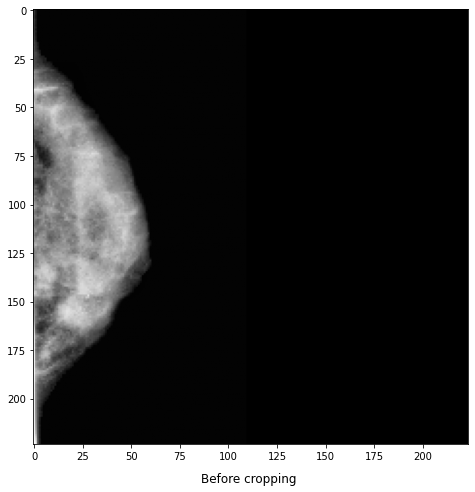

In [44]:
plt.figure(figsize = (50,8))
plt.imshow(res_x.numpy(), cmap="gray")
plt.title(f"Before cropping ", x=0.5, y=-0.1)

(224, 224, 3)


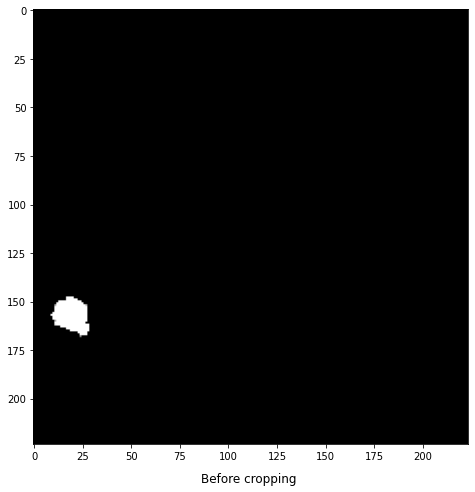

In [45]:
plt.figure(figsize = (50,8))
plt.imshow(res_y.numpy()[:,:,0], cmap="gray")
plt.title(f"Before cropping ", x=0.5, y=-0.1)
print(res_x.numpy().shape)

In [46]:
# res_y.numpy()[:,:,0].shape

In [47]:
# res_x.numpy().shape

In [48]:
prediction = unet.predict(test_ds)

In [49]:
# type(prediction)

In [50]:
# prediction.shape

In [51]:
# prediction[0].shape

(224, 224, 3)


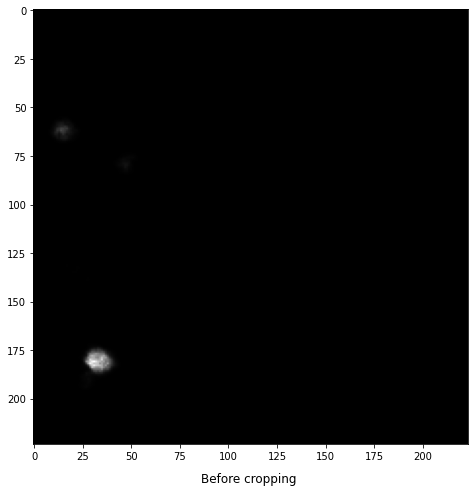

In [52]:
plt.figure(figsize = (50,8))
plt.imshow(prediction[i][:,:,0], cmap="gray")
plt.title(f"Before cropping ", x=0.5, y=-0.1)
print(res_x.numpy().shape)